# Predicting Cardiovascular Disease: A Data-Driven Risk Assessment

## 1. Introduction 

Cardiovascular disease (CVD) is the leading cause of death globally, accounting for million deaths per year. Early identification of at-risk individuals can lead to timely intervention and save lives.  We can do this with data science, as we analyze a dataset with statistics that can indicate if someone has cardiovascular disease.  In our dataset, we collect stats and characteristics of thousands of patients.  We will use various classification algorithms (logistic regression, and ) to train on this data, and predict if someone is going to develop cardiovascular disease just from their characteristics.  

In this project, we analyze patient health metrics to:
- Understand key risk factors
- Build a predictive model for cardiovascular disease
- Provide actionable recommendations for healthcare decision-makers

This type of data work can directly assist health clinics, telemedicine providers, or insurance companies in managing population health more effectively.

Let's look at what columns the data has...


In [1]:
import pandas as pd
import numpy as np

heart_df = pd.read_csv('cardio_train.csv', delimiter = ';')

# number of rows
print("Number of patients in dataset: "+str(len(heart_df)))

heart_df.head(10)

Number of patients in dataset: 70000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


We use an anonymized dataset of 70000 patient records, which have the following columns of data:

`age`, `gender` (1 male, 2 female), `height` (lbs), `weight` (inches), `ap_hi` (systolic BP), `ap_lo` (diastolic BP), `cholesterol`, `gluc`, `smoke`, `alco`, `active`, `cardio` (target: 1 = has cardiovascular disease, 0 = healthy)

The goals in this dataset will be to...

- Perform exploratory data analysis (EDA)  
- Identify top risk factors using visualization and feature importance  
- Train and evaluate classification models (Logistic Regression, Random Forest)  
- Translate findings into real-world policy recommendations

First let us represent the data with graphs to see what what kind of people we are dealing with in this dataset, then we will prepare it for predictions. 


## 2. Data Exploration

As always, with any kaggle dataset, we need to prepare and clean the data to help optimize visualizing the data.  In the next function **cleaner_df**, we will convert the `age` column into years (it is for sure being reported as days alive), and remove duplicates and NaNs.

In [2]:

def cleaner_df(df, map_names):
    
    df.columns = [col.capitalize() for col in df.columns]
    
    # remap column names
    df = df.rename(columns = {'Ap_hi':'Systolic BP', 'Ap_lo':'Diastolic BP', 'Gluc':'Glucose',
                              'Alco':'Alcohol Drinker', 'Active':'Inactive', 'Smoke': 'Smoker',
                              'Cardio':'CVD'})
    
    # create new column 
    df['Age'] = (df['Age'] / 365).astype(int)
    
    # there are no NaNs in this dataset, but I would count them and deal with them another way
    df = df.dropna()
    
    # in case there are some weird bloodpressure readings that could be errors
    df = df[(df['Systolic BP'] > 60) & (df['Systolic BP'] < 220)]
    df = df[(df['Diastolic BP'] > 30) & (df['Diastolic BP'] < 140)]
    
    # we reverse the value of 1 for Exerciser so that you are marked 1 if you don't exercise
    df['Inactive'] = abs(1-df['Inactive'])
    
    # create a BMI category
    df['BMI'] = df['Weight'] / (df['Height']/100)**2
    
    # make category columns for cholestorol and glucose
    df['Cholesterol Category'] = df['Cholesterol'].map(map_names)
    df['Glucose Category'] = df['Glucose'].map(map_names)

    # Check for missing data
    print("Missing values per column:\n", df.isna().sum())
    
    print("Total number of data points after cleaning: "+str(len(df)))
    
    return df

MAP_NAMES = {1: 'Normal', 2: 'Below Normal', 3: 'Well Below Normal'}

clean_heart_df = cleaner_df(heart_df, MAP_NAMES)


Missing values per column:
 Id                      0
Age                     0
Gender                  0
Height                  0
Weight                  0
Systolic BP             0
Diastolic BP            0
Cholesterol             0
Glucose                 0
Smoker                  0
Alcohol Drinker         0
Inactive                0
CVD                     0
BMI                     0
Cholesterol Category    0
Glucose Category        0
dtype: int64
Total number of data points after cleaning: 68691


Before performing any analysis or modeling, we cleaned the data to ensure quality and interpretability:

- **Converted age from days to years** for human-readable analysis. The original `age` column is in days, so we created a new column `age_years = age / 365`.

- **Calculated BMI** using height and weight to explore body composition as a factor:  
  `BMI = weight / (height in meters)^2`
  
- **Dropped duplicate entries** to avoid overrepresenting patients in the analysis.

- **Filtered out extreme blood pressure readings** (e.g., systolic < 80 or > 240) to reduce noise from erroneous inputs.

- **Mapped cholesterol and glucose codes** to readable categories:  
  `1 = normal`, `2 = above normal`, `3 = well above normal`

We also verified that there were **no missing values** in the dataset.  Due to the blood pressure filter we put in, 1307 data points were removed from the set.

Now we introduce our first graph, which is a stacked histogram showing the number of people that have cardiovascular disease 

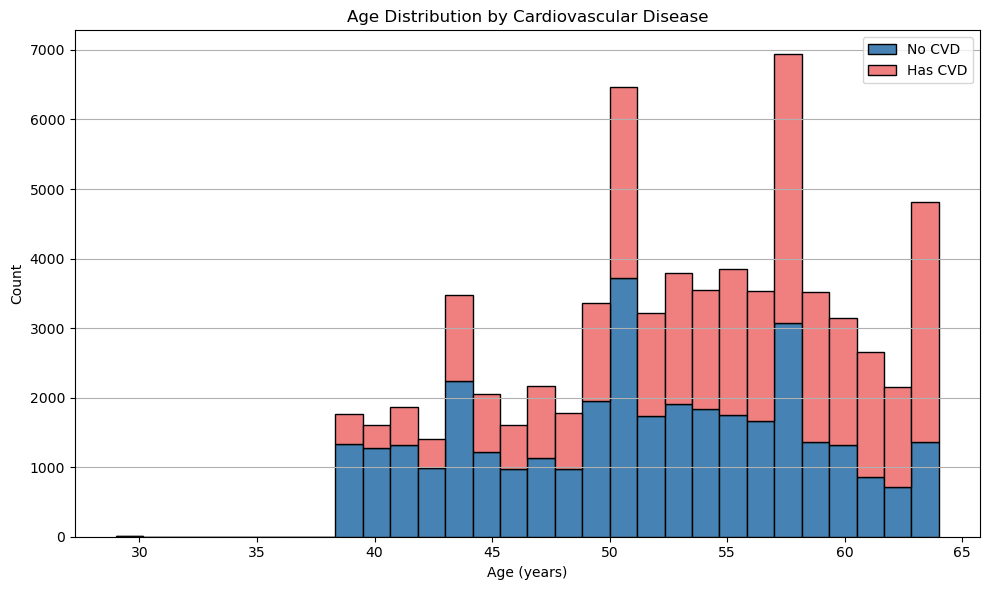

In [3]:
import matplotlib.pyplot as plt

def plot_age_histogram(df):
    plt.figure(figsize=(10, 6))
    
    # Split age groups
    age_no_cvd = df[df['CVD'] == 0]['Age']   # i do not have cardiovascular disease
    age_cvd = df[df['CVD'] == 1]['Age']      # i do have cardiovascular disease
    
    # Plot stacked histogram
    plt.hist([age_no_cvd, age_cvd], bins=30, stacked=True,
             label=['No CVD', 'Has CVD'], color=['steelblue', 'lightcoral'], edgecolor='black')
    
    plt.title('Age Distribution by Cardiovascular Disease')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
plot_age_histogram(clean_heart_df)

This stacked histogram displays the age distribution of patients, separated by cardiovascular disease status:

- **Blue bars** represent patients **without** cardiovascular disease (CVD).

- **Red bars** represent patients **with** cardiovascular disease.

The x-axis shows age in years (converted from days in the original dataset), and the y-axis shows the **count of patients** in each age group.  The majority of patients are between **40 and 65 years old** with the incidence of cardiovascular disease increases significantly after age **50**, which is consistent with known medical trends.  There are **fewer younger patients (under 40)** in this dataset, and among them, CVD is relatively rare.  This distribution reinforces the importance of targeted screening and preventative care for older adults, especially those over 50.

The following code groups the dataset by **age group** and **gender** to calculate the **mean cardiovascular disease (CVD) rate** for each subgroup:

- Patients are binned into four age groups:  
  `<40`, `40–49`, `50–59`, `60–69`.
- Gender is mapped to **Male** and **Female** using the `gender` column.
- For each age-gender combination, we calculate the **percentage of patients with CVD** (`cardio = 1`).
- Finally, we plot a grouped bar chart showing how CVD prevalence changes by age and gender.

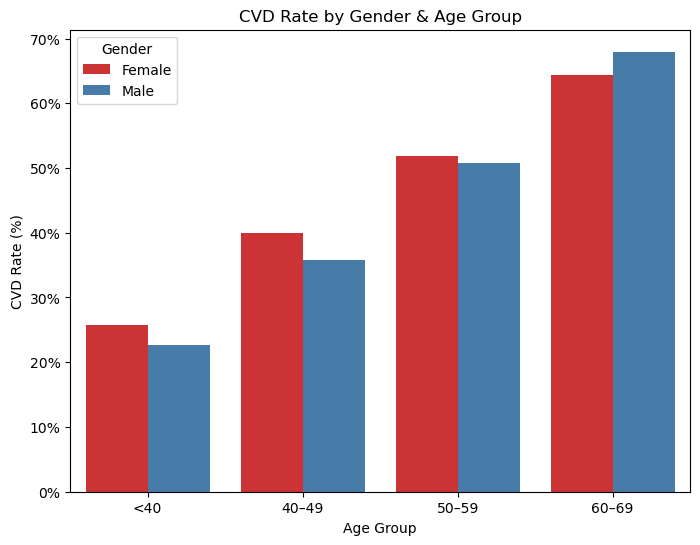

In [4]:
import seaborn as sns

def plot_gender_age_cvd(df):
   
    # age bins n' labels
    bins = [0, 39, 49, 59, 69]
    labels = ['<40', '40–49', '50–59', '60–69']
    
    # make age groups and gender labels
    df['Age Group'] = pd.cut(df['Age'], bins = bins, labels = labels, right = True)
    df['Gender Label'] = df['Gender'].map({1: 'Male', 2: 'Female'})
    
    # average out cvd rates per gender per age group
    cvd_rate = df.groupby(['Age Group', 'Gender Label'])['CVD'].mean().reset_index()
    
    plt.figure(figsize = (8,6))
    
    # seaborn over matplotlib this time
    sns.barplot(data = cvd_rate, x = 'Age Group', y = 'CVD', hue = 'Gender Label', palette = 'Set1')
    
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('Age Group')
    plt.title('CVD Rate by Gender & Age Group')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.legend(title = 'Gender')
    plt.show()
    
plot_gender_age_cvd(clean_heart_df)

We see the comparison of patients with CVD by gender across different age groups.  We clearly see that CVD risk increases with age for both genders, with men dominating in the age groups 60 and above.  The risk factor increases with age not gender.

The next bar graph shows the percentage of patients with CVD by BMI category:  The code bins each patient into a **BMI category** and calculates the percentage of patients with cardiovascular disease (CVD) in each group.  Remember that BMI is calculated as `weight (kg) / (height (m)^2)`.

The Patients are categorized into:  
  - Underweight: `<18.5`  
  - Normal weight: `18.5–24.9`  
  - Overweight: `25–29.9`  
  - Obese: `30+`

For each BMI category, we calculate the **CVD prevalence** (mean of `cardio = 1`).

$$\text{CVD Prevalence} = \frac{\text{Number of patients with CVD}}{\text{Total number of patients in the group}} \times 100 $$

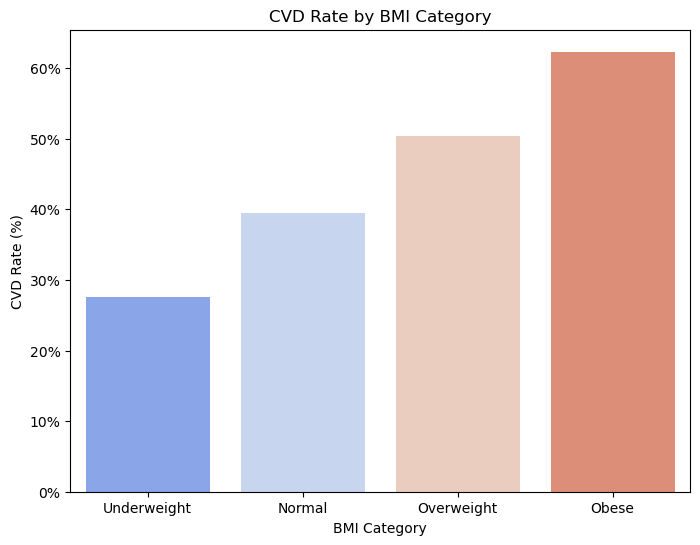

In [5]:

def plot_bmi_cvd(df):
    
    # bin the BMIs
    bins = [0, 18.5, 24.9, 29.9, 100]
    labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    df['BMI Cat'] = pd.cut(df['BMI'], bins = bins, labels = labels)
    
    #
    bmi_rate = df.groupby('BMI Cat')['CVD'].mean().reset_index()
    
    plt.figure(figsize = (8,6))
    sns.barplot(data = bmi_rate, x = 'BMI Cat', y = 'CVD', palette = 'coolwarm')
    
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('BMI Category')
    plt.title('CVD Rate by BMI Category')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.show()
    
    
plot_bmi_cvd(clean_heart_df)

We see that the CVD prevalence **increases with BMI**, with obese individuals having the highest rates.  Underweight individuals show lower CVD prevalence, but the smallest sample size may limit insight.  More or less, we see that obesity increases CVD risk.

Our next graph calculates the CVD risk per total number of risk factors.

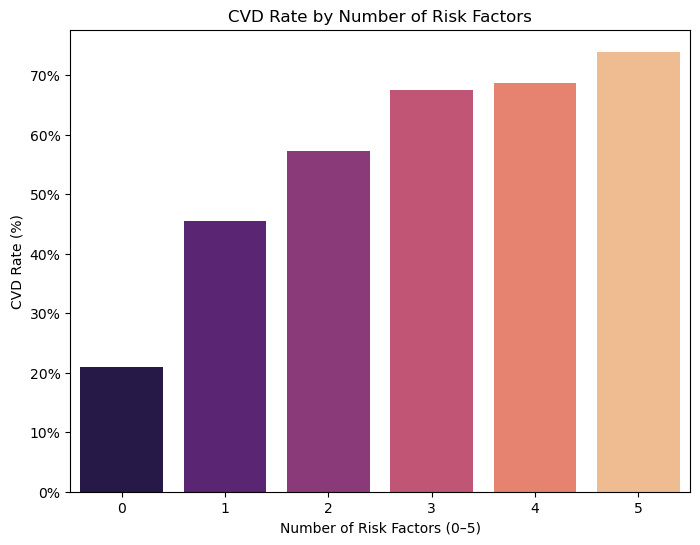

In [6]:

def plot_riskfactor_cvd(df):

    # Risk factors: smoke, inactive, high BP, high cholesterol, high glucose
    df['High Blood Pressure'] = ((df['Systolic BP'] >= 130) | (df['Diastolic BP'] >= 80)).astype(int)
    df['High Cholesterol'] = (df['Cholesterol'] > 1).astype(int)
    df['High Glucose'] = (df['Glucose'] > 1).astype(int)
    
    # Sum up totals for the risk count (ensure column names match your renamed columns)
    df['Risk Count'] = (df['Smoker'] + df['Inactive'] + df['High Blood Pressure'] + 
        df['High Cholesterol'] + df['High Glucose'])

    # Group and calculate CVD rate
    risk_rate = df.groupby('Risk Count')['CVD'].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=risk_rate, x='Risk Count', y='CVD', palette='magma')

    # Clean x-axis and format
    plt.xticks(ticks=range(len(risk_rate['Risk Count'])), labels=risk_rate['Risk Count'])
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('Number of Risk Factors (0–5)')
    plt.title('CVD Rate by Number of Risk Factors')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.show()

plot_riskfactor_cvd(clean_heart_df)

The risk of CVD **rises sharply** with each additional risk factor.  Patients with **4 or 5 risk factors** have the highest CVD prevalence (over 70%).  This highlights the cumulative effect of lifestyle and clinical risk factors on heart health!

We will now use boxplots to compare **Systolic Blood Pressure (SBP)** and **Diastolic Blood Pressure (DBP)** distributions between patients **with CVD (`CVD = 1`)** and those **without CVD (`CVD = 0`)**.  The boxplot shows the **median**, **interquartile range (IQR)**, and **outliers** for each group.  This visualization is useful because blood pressure is a continuous variable, and we want to see how its distribution shifts depending on CVD status.  Blood pressure is an important risk factor for cardiovascular disease, and boxplots allow us to visualize **central tendency** (median) and **variability**, compare distributions directly between groups and detect **systematic differences** (e.g., higher blood pressure in the CVD group).


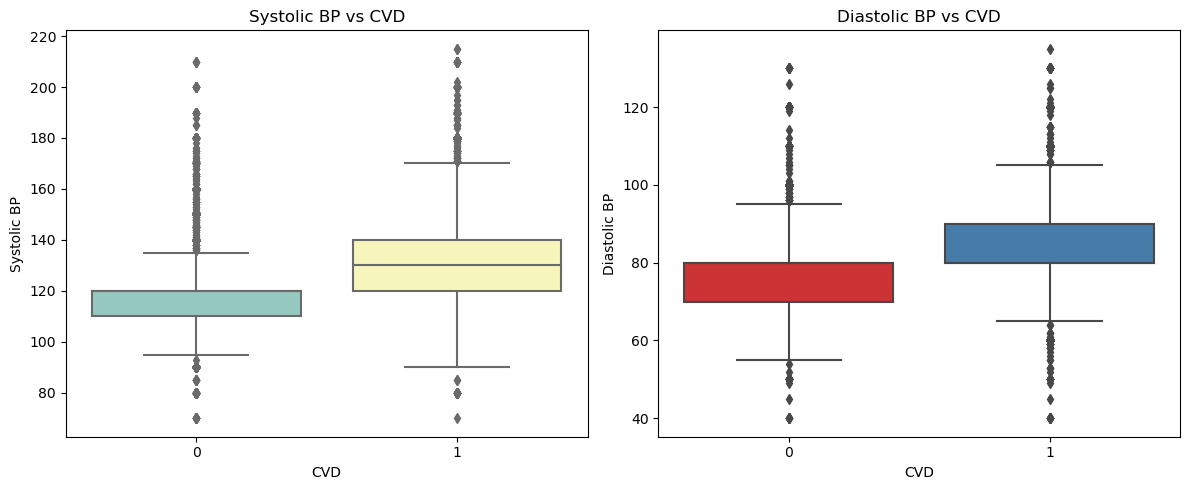

In [7]:

def plot_blood_pressure_box(df):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data = df, x = 'CVD', y = 'Systolic BP', palette = 'Set3')
    
    plt.title('Systolic BP vs CVD')
    plt.subplot(1, 2, 2)
    
    sns.boxplot(data = df, x = 'CVD', y = 'Diastolic BP', palette = 'Set1')
    
    plt.title('Diastolic BP vs CVD')
    plt.tight_layout()
    plt.show()
    
plot_blood_pressure_box(clean_heart_df)

Both **systolic** and **diastolic** blood pressure levels are generally **higher** in patients with CVD compared to those without.  The median SBP and DBP are shifted upward in the CVD group, suggesting that elevated blood pressure is strongly associated with cardiovascular disease.  The IQR (spread) is also slightly wider in the CVD group, meaning there is more variability in blood pressure among these patients.  Outliers are present in both groups, but are more common in the non-CVD group for SBP, which may indicate occasional isolated high readings not associated with diagnosed CVD.  These plots reinforce the established relationship between elevated blood pressure and cardiovascular disease risk. 

Next, the `plot_stacked_bar()` function generates **stacked bar charts** that show the proportion of patients with and without cardiovascular disease (CVD) within each category of a specific lab measurement:

1. **Descriptive Labels:** The function maps numeric codes (1, 2, 3) for glucose and cholesterol levels into human-readable labels (e.g., "Normal", "Above Normal", "Well Above").

2. **Cross-Tabulation:** Using `pd.crosstab()`, it calculates the percentage of patients in each `CVD` category (`0 = No CVD`, `1 = Has CVD`) for each level of the selected feature.

3. **Stacked Bar Chart:** Each bar shows the breakdown of CVD vs no CVD for each level of glucose or cholesterol.

This is an important plot because it shows how **CVD prevalence changes across biomarker categories**.  The graph is **percentage-based**, as it makes it easy to see trends even if sample sizes vary between categories.

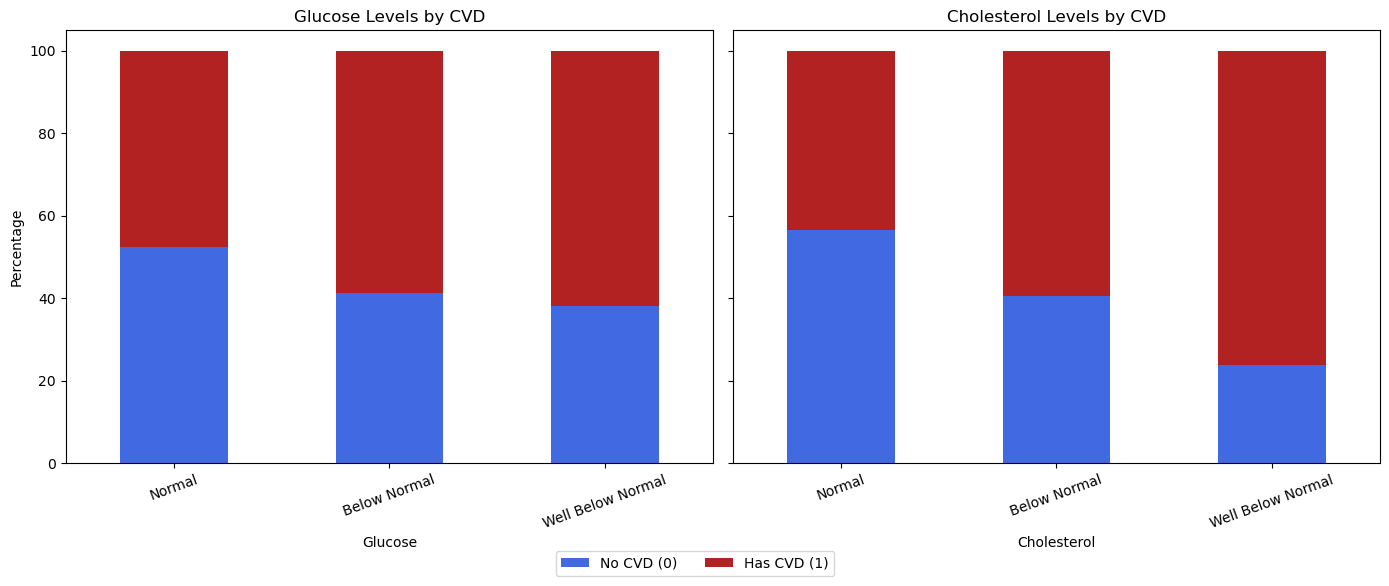

In [8]:
def plot_stacked_bar(df, label_map):
    
    df = df.copy()
    df['Glucose_Label'] = df['Glucose'].map(label_map)
    df['Cholesterol_Label'] = df['Cholesterol'].map(label_map)
    
    order = list(label_map.values())

    # Create cross-tabs
    glucose_tab = pd.crosstab(df['Glucose_Label'], df['CVD'], normalize = 'index') * 100
    chol_tab = pd.crosstab(df['Cholesterol_Label'], df['CVD'], normalize = 'index') * 100

    fig, axes = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # Glucose subplot
    glucose_tab.loc[order].plot(kind = 'bar', stacked = True, ax = axes[0], color = ['royalblue', 'firebrick'])
    axes[0].set_title('Glucose Levels by CVD')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Glucose')
    axes[0].set_xticklabels(order, rotation = 20)
    axes[0].get_legend().remove()  # remove legend from subplot

    # Cholesterol subplot
    chol_tab.loc[order].plot(kind = 'bar', stacked = True, ax = axes[1], color = ['royalblue', 'firebrick'])
    axes[1].set_title('Cholesterol Levels by CVD')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Cholesterol')
    axes[1].set_xticklabels(order, rotation = 20)
    axes[1].get_legend().remove()  # remove legend from subplot

    # Shared legend at the bottom
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, ['No CVD (0)', 'Has CVD (1)'],
               loc = 'lower center', ncol = 2, bbox_to_anchor = (0.5, 0.02))

    plt.tight_layout(rect = [0, 0.05, 1, 1])
    plt.show()

plot_stacked_bar(clean_heart_df, MAP_NAMES)

This combined stacked bar chart compares the percentage of patients with and without cardiovascular disease (CVD) across different levels of **glucose** and **cholesterol**:  The labels on the x axis correspond to the same labels from earlier in this section for the **cholesterol** and **glucose** rankings (1 = normal, 2 = below normal, 3 = well below normal). For both **glucose** and **cholesterol**, the proportion of patients with CVD **increases as levels rise**.  The **"Well Below" cholesterol group** shows the most dramatic difference, with nearly **75% of patients having CVD**.  Patients with **normal biomarker levels** have a lower CVD prevalence, though a substantial proportion are still affected.  So as we can see, elevated glucose and cholesterol levels are strongly associated with a higher prevalence of cardiovascular disease. This reinforces the importance of managing these biomarkers as part of CVD prevention strategies.

Our last graph will be a violin (manta ray) graph to show the weight distribution for patients with and without CVD.  A **violin plot** is ideal for showing the distribution of a continuous variable (like weight) across different categories (CVD vs no CVD). It combines the features of a boxplot and a kernel density estimate.  The **width** of each violin shows the **density** of observations at different values.  The **box** inside represents the interquartile range (IQR) and the median.  This gives a more complete picture of the data distribution compared to a boxplot alone, highlighting multimodality or skewness.

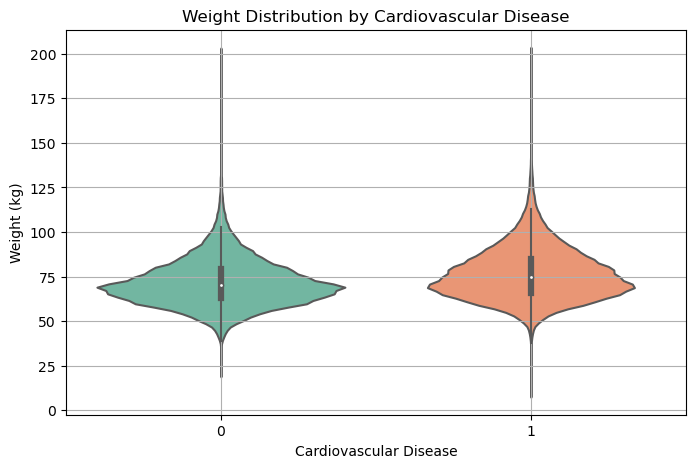

In [9]:

def plot_violin_weight(df):
    
    plt.figure(figsize = (8, 5))
    sns.violinplot(data = df, x = 'CVD', y = 'Weight', palette = 'Set2')
    plt.title('Weight Distribution by Cardiovascular Disease')
    plt.xlabel('Cardiovascular Disease')
    plt.ylabel('Weight (kg)')
    plt.grid(True)
    plt.show()
    
plot_violin_weight(clean_heart_df)

The shapes of the violins display how weight is distributed for each group.  Patients **with CVD** tend to have a slightly higher weight distribution.  The median weight and the spread of weights are greater in the CVD group compared to the non-CVD group.  There are some extreme outliers (very low and very high weights) visible as narrow tips.

In this section, we analyzed several features from the dataset to better understand their relationship with **cardiovascular disease (CVD)**:  
- **Demographics:** Age and gender distributions clearly showed that CVD prevalence increases with age.  
- **Biomarkers & Lifestyle:** Elevated cholesterol, glucose, blood pressure, and BMI were all strongly associated with higher CVD rates.  
- **Risk Factor Counts:** CVD prevalence rose sharply as patients accumulated more risk factors.  
- **Distribution Analysis:** Continuous variables like weight and blood pressure displayed clear differences in distribution between CVD and non-CVD groups.

These insights guide us in selecting features and transforming the dataset for predictive modeling.  In the next section we are going to use various algorithms to build predictive models that can use our data to determine if a new patient is at risk for CVD

## 3.  Creating a Predictive Model for CVD Using Logistic Regression

LogisticRegression from scikit-learn is a supervised machine learning algorithm used for binary and multiclass classification problems. Instead of predicting continuous values like linear regression, it estimates the probability that a data point belongs to a particular class using the logistic (sigmoid) function.

In a binary classification setup (e.g., predicting cardiovascular disease CVD or not), the model outputs probabilities between 0 and 1, and a threshold (usually 0.5) is used to assign class labels. Logistic Regression also supports regularization (via the C and penalty parameters) to prevent overfitting, and multiple optimization algorithms (defined by the solver parameter) for flexibility and scalability.

This makes LogisticRegression a great baseline model that is interpretable, fast to train, and performs well on structured/tabular data.

In order to optimize the results and create the best predictive model for this dataset, we need to send the most impactful categories to **logisticRegression**.  The categories we will use to train the data will be: `Age`, `Cholesterol`, `Glucose`, `Smoker`, `Alcohol Drinker`, `Inactive`, `BMI`, `High BP`.  The function that will be introduced will bin `Age` and `BMI` into integer values to make the fitting much easier.

In [15]:
def logreg_prep(df):

    # high blood pressure
    df['High_BP'] = ((df['Systolic BP'] >= 130) | (df['Diastolic BP'] >= 80)).astype(int)
    
    # interactions
    df['AgeXBP']  = df['Age'] * df['High_BP']
    df['BMIGluc'] = df['BMI'] * df['Glucose']
    # log transforms
    
    df['Chol_log'] = np.log1p(df['Cholesterol'])
    df['Gluc_log'] = np.log1p(df['Glucose'])
    
    # squared terms
    df['Age2'] = df['Age']**2
    df['BMI2'] = df['BMI']**2
    
    df['Glucose2']    = df['Glucose'] ** 2
    df['Cholesterol2']= df['Cholesterol'] ** 2

    # or a logit-style feature:
    df['LogOddsAge']  = np.log1p(df['Age'] / (100 - df['Age']))
    
    return df


Now that we have our selected categories, we can plug them into our **LogisticRegression** fron **sklearn**.  We will set up a gridsearch for the best parameters as we parse through the following:

- C: Regularization Strength (a measurement of the strictness of the model).  Large C can lead to overfitting and small C can underfit the model
- penalty: Determines the type of regularization applied to the model coefficients.
- solver: Algorithm used to optimize the logistic regression cost function.​  PArticular solvers work the best with particular penaltys 

We will use a small linear space with **np.linspace** for C, and search between l1 and l2 penalties with various solvers.

/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eb64/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

LR best params: {'clf__C': 5.488983292093406, 'clf__l1_ratio': 0.7607560696646062}
Val AUC — LR: 0.720 | RandomForest: 0.719 | Blend: 0.721 (alpha=0.50)
Selected: Blend | Best val threshold (balanced acc): 0.499

📊 Test Metrics (chosen model)
ROC-AUC : 0.723
Accuracy: 0.661
Precision: 0.655
Recall   : 0.666
F1       : 0.660
              precision    recall  f1-score   support

           0      0.668     0.656     0.662      6945
           1      0.655     0.666     0.660      6794

    accuracy                          0.661     13739
   macro avg      0.661     0.661     0.661     13739
weighted avg      0.661     0.661     0.661     13739



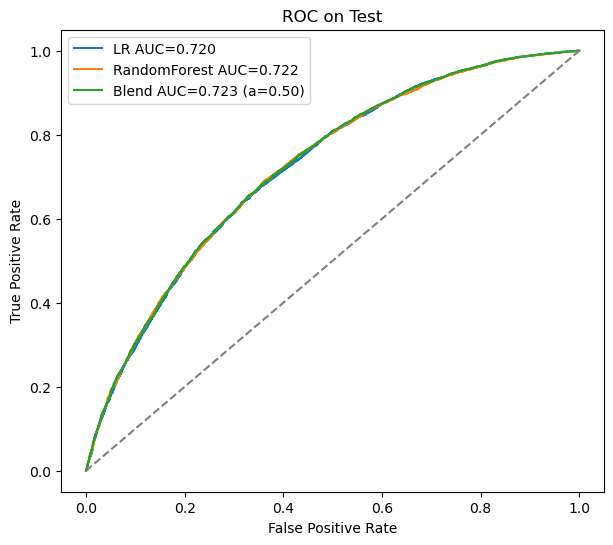

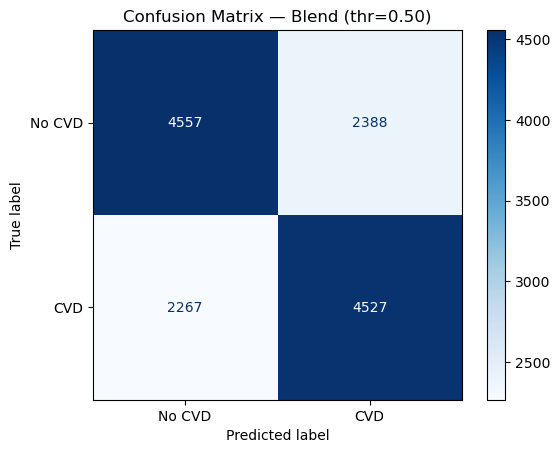

In [21]:
def run_lr_lgbm_blend(df, features, random_state=21, n_iter=16, cv=3):
    # Split train/test, then carve validation out of train
    X = df[features].copy()
    y = df['CVD'].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.20, random_state=random_state
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, stratify=y_train, test_size=0.15, random_state=random_state
    )

    # Scale for LR (trees use raw features)
    scaler = StandardScaler()
    X_tr_s  = scaler.fit_transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_test_s= scaler.transform(X_test)

    # ----- Resampling for LR (prefer SMOTETomek; fallback to upsample) -----
    try:
        from imblearn.combine import SMOTETomek
        smt = SMOTETomek(random_state=random_state)
        X_res_lr, y_res_lr = smt.fit_resample(X_tr_s, y_tr)
    except Exception:
        tr_s = pd.DataFrame(X_tr_s, columns=features)
        tr_s['CVD'] = y_tr.values
        maj, min_ = tr_s[tr_s.CVD==0], tr_s[tr_s.CVD==1]
        min_up = resample(min_, replace=True, n_samples=len(maj), random_state=random_state)
        bal = pd.concat([maj, min_up])
        X_res_lr, y_res_lr = bal.drop(columns='CVD').values, bal['CVD'].values

    # ----- Elastic-Net Logistic (randomized search) -----
    lr_pipe = Pipeline([
        ('clf', LogisticRegression(
            penalty='elasticnet', solver='saga',
            max_iter=5000, class_weight='balanced',
            random_state=random_state
        ))
    ])
    lr_param_dist = {
        'clf__C': loguniform(0.01, 10),
        'clf__l1_ratio': uniform(0, 1)
    }
    lr_search = RandomizedSearchCV(
        lr_pipe, lr_param_dist, n_iter=n_iter, cv=cv,
        scoring='roc_auc', n_jobs=-1, random_state=random_state
    )
    lr_search.fit(X_res_lr, y_res_lr)
    lr_best = lr_search.best_estimator_
    print("LR best params:", lr_search.best_params_)

    p_lr_val  = lr_best.predict_proba(X_val_s)[:, 1]
    p_lr_test = lr_best.predict_proba(X_test_s)[:, 1]
    auc_lr_val = roc_auc_score(y_val, p_lr_val)

    # ----- Tree model: LightGBM if available, else RandomForest fallback -----
    try:
        import lightgbm as lgb
        tree = lgb.LGBMClassifier(
            n_estimators=300, max_depth=4, learning_rate=0.08,
            subsample=0.9, colsample_bytree=0.9,
            class_weight='balanced', random_state=random_state
        )
        # simple upsample for parity
        tr_raw = X_tr.copy(); tr_raw['CVD'] = y_tr.values
        maj_r, min_r = tr_raw[tr_raw.CVD==0], tr_raw[tr_raw.CVD==1]
        min_up_r = resample(min_r, replace=True, n_samples=len(maj_r), random_state=random_state)
        bal_r = pd.concat([maj_r, min_up_r])
        X_res_tree, y_res_tree = bal_r.drop(columns='CVD'), bal_r['CVD']
        tree.fit(X_res_tree, y_res_tree)
        p_tree_val  = tree.predict_proba(X_val)[:, 1]
        p_tree_test = tree.predict_proba(X_test)[:, 1]
        tree_name = 'LGBM'
    except Exception:
        from sklearn.ensemble import RandomForestClassifier
        tree = RandomForestClassifier(
            n_estimators=400, max_depth=8, min_samples_leaf=20,
            class_weight='balanced', n_jobs=-1, random_state=random_state
        )
        tr_raw = X_tr.copy(); tr_raw['CVD'] = y_tr.values
        maj_r, min_r = tr_raw[tr_raw.CVD==0], tr_raw[tr_raw.CVD==1]
        min_up_r = resample(min_r, replace=True, n_samples=len(maj_r), random_state=random_state)
        bal_r = pd.concat([maj_r, min_up_r])
        X_res_tree, y_res_tree = bal_r.drop(columns='CVD'), bal_r['CVD']
        tree.fit(X_res_tree, y_res_tree)
        p_tree_val  = tree.predict_proba(X_val)[:, 1]
        p_tree_test = tree.predict_proba(X_test)[:, 1]
        tree_name = 'RandomForest'

    auc_tree_val = roc_auc_score(y_val, p_tree_val)

    # ----- Blend: search alpha in [0..1] on validation AUC -----
    alphas = np.linspace(0, 1, 21)
    blend_aucs = []
    for a in alphas:
        p_val_blend = a*p_lr_val + (1-a)*p_tree_val
        blend_aucs.append(roc_auc_score(y_val, p_val_blend))
    a_best = alphas[int(np.argmax(blend_aucs))]
    auc_blend_val = max(blend_aucs)

    print(f"Val AUC — LR: {auc_lr_val:.3f} | {tree_name}: {auc_tree_val:.3f} | Blend: {auc_blend_val:.3f} (alpha={a_best:.2f})")

    # ----- Choose winner by validation AUC -----
    if auc_blend_val >= max(auc_lr_val, auc_tree_val):
        choice = 'Blend'
        p_test = a_best*p_lr_test + (1-a_best)*p_tree_test
        p_val_choice = a_best*p_lr_val + (1-a_best)*p_tree_val
    elif auc_lr_val >= auc_tree_val:
        choice = 'Logistic'
        p_test = p_lr_test
        p_val_choice = p_lr_val
    else:
        choice = tree_name
        p_test = p_tree_test
        p_val_choice = p_tree_val

    # ----- Pick threshold by balanced accuracy on validation -----
    fpr, tpr, thr = roc_curve(y_val, p_val_choice)
    tnr = 1 - fpr
    bacc = (tpr + tnr) / 2.0
    t_best = thr[int(np.argmax(bacc))]
    print(f"Selected: {choice} | Best val threshold (balanced acc): {t_best:.3f}")

    # ----- Final test metrics for chosen model -----
    y_pred = (p_test >= t_best).astype(int)
    test_auc = roc_auc_score(y_test, p_test)
    print("\n📊 Test Metrics (chosen model)")
    print(f"ROC-AUC : {test_auc:.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
    print(f"F1       : {f1_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # Plot ROC for all three on test
    f_lr, t_lr, _ = roc_curve(y_test, p_lr_test)
    f_tr, t_tr, _ = roc_curve(y_test, p_tree_test)
    p_bl_test = a_best*p_lr_test + (1-a_best)*p_tree_test
    f_bl, t_bl, _ = roc_curve(y_test, p_bl_test)

    plt.figure(figsize=(7,6))
    plt.plot(f_lr, t_lr, label=f'LR AUC={roc_auc_score(y_test, p_lr_test):.3f}')
    plt.plot(f_tr, t_tr, label=f'{tree_name} AUC={roc_auc_score(y_test, p_tree_test):.3f}')
    plt.plot(f_bl, t_bl, label=f'Blend AUC={roc_auc_score(y_test, p_bl_test):.3f} (a={a_best:.2f})')
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC on Test'); plt.legend(); plt.show()

    # Confusion matrix for chosen model
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
        display_labels=['No CVD','CVD'], cmap='Blues')
    plt.title(f'Confusion Matrix — {choice} (thr={t_best:.2f})'); plt.show()

    return {
        'choice': choice,
        'alpha': float(a_best),
        'lr_model': lr_best,
        'tree_model': tree,
        'scaler': scaler,
        'threshold': float(t_best),
        'val_auc': {'LR': float(auc_lr_val), tree_name: float(auc_tree_val), 'Blend': float(auc_blend_val)},
        'test_auc': float(test_auc)
    }


logreg_df = logreg_prep(clean_heart_df)
features = ['Age','Cholesterol','Glucose','Chol_log','Gluc_log','Smoker','Inactive',
             'Alcohol Drinker','BMI','Age2','BMI2','High_BP','AgeXBP','BMIGluc',
             'Glucose2','Cholesterol2','LogOddsAge']

results = run_lr_lgbm_blend(logreg_df, features)
# results
#logreg_df = logreg_prep(clean_heart_df)


#columns = ['Age', 'Cholesterol', 'Glucose', 'Chol_log', 'Gluc_log', 'Smoker', 'Inactive', 'Alcohol Drinker',
#       'BMI', 'Age2', 'BMI2', 'High_BP', 'AgeXBP', 'BMIGluc', 'Glucose2', 'Cholesterol2', 'LogOddsAge']

#model, scaler, threshold = run_advanced_logreg(logreg_df, columns)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier

# ---------- utilities ----------
def _balanced_sample_weight(y):
    classes = np.array([0, 1])
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    wmap = {c: wt for c, wt in zip(classes, w)}
    return np.array([wmap[yy] for yy in y])

def _metric_row(name, y_val, p_val, y_test, p_test):
    return {
        "model": name,
        "val_auc":  roc_auc_score(y_val,  p_val),
        "val_pr":   average_precision_score(y_val,  p_val),
        "test_auc": roc_auc_score(y_test, p_test),
        "test_pr":  average_precision_score(y_test, p_test),
    }

# ---------- 1) HistGradientBoosting (sklearn) ----------
def fit_histgb_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state=42):
    sw = _balanced_sample_weight(y_tr)
    hgb = HistGradientBoostingClassifier(
        loss="log_loss",
        learning_rate=0.10,
        max_depth=None,              # shallow trees are fast; None lets it choose
        max_bins=255,
        min_samples_leaf=20,
        l2_regularization=0.0,
        early_stopping=True,
        validation_fraction=0.15,
        random_state=random_state
    )
    hgb.fit(X_tr, y_tr, sample_weight=sw)
    p_val  = hgb.predict_proba(X_val)[:, 1]
    p_test = hgb.predict_proba(X_test)[:, 1]
    metrics = _metric_row("HistGB", y_val, p_val, y_test, p_test)
    return hgb, p_val, p_test, metrics

# ---------- 2) LightGBM (CPU) with early stopping ----------
def fit_lightgbm_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state=42):
    try:
        import lightgbm as lgb
    except Exception as e:
        raise ImportError("lightgbm is not installed. `pip install lightgbm`") from e

    lgbm = lgb.LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.03,
        num_leaves=31,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state,
    )
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    p_val  = lgbm.predict_proba(X_val)[:, 1]
    p_test = lgbm.predict_proba(X_test)[:, 1]
    metrics = _metric_row("LightGBM", y_val, p_val, y_test, p_test)
    return lgbm, p_val, p_test, metrics

# ---------- 3) CatBoost (CPU) with early stopping ----------
def fit_catboost_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state=42):
    try:
        from catboost import CatBoostClassifier
    except Exception as e:
        raise ImportError("catboost is not installed. `pip install catboost`") from e

    # class weights like 'balanced'
    w = compute_class_weight("balanced", classes=np.array([0,1]), y=y_tr)
    cb = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=6,
        loss_function="Logloss",
        eval_metric="AUC",
        class_weights=list(w),       # [w0, w1]
        random_seed=random_state,
        od_type="Iter",
        od_wait=200,                 # early stopping rounds
        verbose=False,
        allow_writing_files=False
    )
    cb.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True, verbose=False)
    p_val  = cb.predict_proba(X_val)[:, 1]
    p_test = cb.predict_proba(X_test)[:, 1]
    metrics = _metric_row("CatBoost", y_val, p_val, y_test, p_test)
    return cb, p_val, p_test, metrics

# ---------- master runner ----------
def run_all_gbm_baselines(df, features, target="CVD", random_state=42):
    """
    Splits data once (train/val/test), then trains and evaluates:
      - HistGradientBoosting
      - LightGBM (if installed)
      - CatBoost (if installed)
    Returns a dict with models, probabilities, and a metrics DataFrame sorted by val AUC.
    """
    X = df[features].copy()
    y = df[target].astype(int).copy()

    # Train / Test split (20% test), then carve 15% of train for validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.20, random_state=random_state
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, stratify=y_train, test_size=0.15, random_state=random_state
    )

    results = []
    models = {}
    probs  = {}

    # 1) HistGB
    hgb, p_val_h, p_test_h, m_h = fit_histgb_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state)
    results.append(m_h); models["HistGB"] = hgb; probs["HistGB"] = {"val": p_val_h, "test": p_test_h}

    # 2) LightGBM (optional)
    try:
        lgbm, p_val_l, p_test_l, m_l = fit_lightgbm_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state)
        results.append(m_l); models["LightGBM"] = lgbm; probs["LightGBM"] = {"val": p_val_l, "test": p_test_l}
    except ImportError as e:
        print(str(e))

    # 3) CatBoost (optional)
    try:
        cb, p_val_c, p_test_c, m_c = fit_catboost_baseline(X_tr, y_tr, X_val, y_val, X_test, y_test, random_state)
        results.append(m_c); models["CatBoost"] = cb; probs["CatBoost"] = {"val": p_val_c, "test": p_test_c}
    except ImportError as e:
        print(str(e))

    metrics_df = pd.DataFrame(results).sort_values("val_auc", ascending=False).reset_index(drop=True)
    return {"metrics": metrics_df, "models": models, "probs": probs,
            "splits": {"X_val": X_val, "y_val": y_val, "X_test": X_test, "y_test": y_test}}

# ---------- example call ----------
prepared_df = logreg_prep(clean_heart_df)   # reuse your prep if you like
FEATURES = ['Age','Cholesterol','Glucose','Smoker','Inactive','Alcohol Drinker',
             'BMI','High_BP','AgeXBP','BMIGluc','Chol_log','Gluc_log','Age2','BMI2',
             'Glucose2','Cholesterol2','LogOddsAge']
out = run_all_gbm_baselines(prepared_df, FEATURES)
display(out["metrics"])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23096, number of negative: 23613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 46709, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,model,val_auc,val_pr,test_auc,test_pr
0,CatBoost,0.726239,0.708249,0.720755,0.697613
1,LightGBM,0.725655,0.708196,0.718940,0.695229
2,HistGB,0.724286,0.705343,0.717525,0.693513
